# 1. Import thư viện

In [1]:
#
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
#
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

# 2. Dataset

In [2]:
# dir
train_dir = '/kaggle/input/radardataset/training_set/'
test_dir = '/kaggle/input/radardataset/test_set/'

In [3]:
def getALLImages(img_dir):
    list_images = []
    list_labels = []
    list_subfolders = []
    subfoler_names = os.listdir(train_dir)
    for i, subfolder in enumerate(subfoler_names):
        # image name
        temp1 = os.listdir(img_dir + subfolder)
        list_images += temp1
        # label, subfolders
        list_labels += [i for j in range(len(temp1))]
        list_subfolders += [subfoler_names[i] for j in range(len(temp1))]
    return list_images, list_labels, list_subfolders

In [4]:
list_train_images, list_train_labels, list_train_subfolders = getALLImages(train_dir)
list_test_images, list_test_labels, list_test_subfolders = getALLImages(test_dir)

In [5]:
print('Số lượng dữ liệu ở tập train: ', len(list_train_images))
print('Số lượng dữ liệu ở tập test: ', len(list_test_images))

Số lượng dữ liệu ở tập train:  6400
Số lượng dữ liệu ở tập test:  4800


In [6]:
class MyDataset(Dataset):
    def __init__(self, img_dir, list_images, list_subfolders, list_labels):
        self.img_dir = img_dir
        self.list_images = list_images
        self.list_labels = list_labels
        self.list_subfolders = list_subfolders
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.list_images)
    def __getitem__(self, idx):
        subfolder_name = self.list_subfolders[idx] + '/'
        image = Image.open(self.img_dir + subfolder_name + self.list_images[idx])
        image = self.transform(image)
        label = self.list_labels[idx]
        return image, label

In [7]:
train_dataset = MyDataset(train_dir, list_train_images, list_train_subfolders, list_train_labels)
test_dataset = MyDataset(test_dir, list_test_images, list_test_subfolders, list_test_labels)

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = 16)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size = 1000)

In [9]:
a, b = next(iter(train_dataloader))

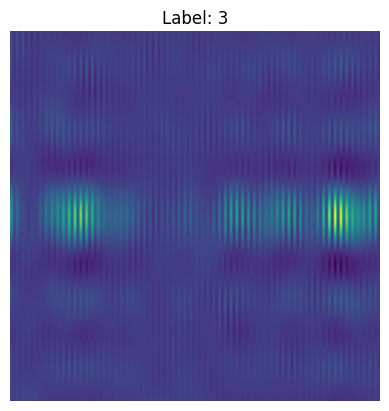

In [10]:
# Visualization dataset
index = torch.randint(0, 16, (1,))
plt.imshow(a[index[0]].permute(1,2,0))
plt.title(f'Label: {b[index[0]]}')
plt.axis('off')
plt.show()

# 3. Train

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32768,84)
        self.fc2 = nn.Linear(84, 8)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, images):
        x = self.relu(self.conv1(images))
        x = self.bn1(x)
        x = self.maxPool(x) 
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = MyModel().to(device)
CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print('Số lượng tham số trong mô hình', total_params)

Số lượng tham số trong mô hình 2758172


In [16]:
def train(model, num_epochs, train_loader):
    for epoch in range(num_epochs):
        best_loss = 999
        total_loss = 0
        model.train()
        for img, label in tqdm(train_loader):
            img, label = img.to(device), label.to(device)
            #
            optimizer.zero_grad()
            #
            output = model(img)
            loss = CE_loss(output, label)
            total_loss += loss.item()
            #
            loss.backward()
            optimizer.step()
        if total_loss <= best_loss:
            best_loss = total_loss
            file_path = '/kaggle/working/best_model.pth'
            torch.save(model.state_dict(), file_path)
        print(f'Epoch {epoch}: {total_loss/len(train_loader)}')

In [17]:
# # Dùng để train tiếp nếu như train 1 lúc 40 epoch không đủ
# file_path = '/kaggle/working/best_model.pth'
# state_dict = torch.load(file_path)
# model.load_state_dict(state_dict)
# model.to(device)

In [23]:
train(model, 10, train_dataloader)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0: 0.1062770455412101


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1: 0.09464082979837257


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2: 0.08808214076590958


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3: 0.07765972646666341


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4: 0.06766142452070198


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5: 0.08014306796841993


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6: 0.05845330299684065


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7: 0.057650730824680065


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8: 0.062336331995611546


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9: 0.054135695040477


# 4. Test

In [21]:
def test(model, test_dataloader):
    correct = 0
    total_loss = 0
    model.eval()
    for img, label in tqdm(test_dataloader):
        img, label = img.to(device), label.to(device)
        with torch.no_grad():
            output = model(img)
            loss = CE_loss(output, label)
            total_loss += loss.item()
            _, predicted_label = torch.max(output, dim = 1)
            correct += (predicted_label==label).sum().item()
    print(f'Accuracy: {correct*100/len(list_test_images)} Loss: {total_loss}')

In [24]:
test(model, test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 77.04166666666667 Loss: 9.628177918493748
